In [256]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import yfinance as yf


In [257]:
import yfinance as yf

ticker = str(input(""))
ticker = ticker.upper()

# Download data without the 'columns' argument
data = yf.download(ticker, period="10y", auto_adjust=True, interval="1mo")
data = data.reset_index()
print(data.head(5000))


[*********************100%%**********************]  1 of 1 completed

          Date        Open        High         Low       Close     Volume
0   2014-03-01  109.310187  112.593446  104.316540  107.857643   97798400
1   2014-04-01  108.502247  113.023176  104.789242  110.891640   77966900
2   2014-05-01  110.650997  116.409590  110.247034  116.246284   61514500
3   2014-06-01  117.114622  119.612490  109.076494  109.966743   78754100
4   2014-07-01  110.338393  112.862189  104.072112  104.132614  111816600
..         ...         ...         ...         ...         ...        ...
115 2023-10-01  191.470001  199.619995  176.250000  186.820007  132929900
116 2023-11-01  189.690002  233.000000  187.500000  231.630005  119254800
117 2023-12-01  231.770004  267.540009  230.000000  260.660004  120189000
118 2024-01-01  257.279999  258.589996  198.320007  211.039993  319496500
119 2024-02-01  213.839996  214.630005  197.149994  200.830002  111968254

[120 rows x 6 columns]


In [258]:
train_dates = pd.to_datetime(data['Date'])
cols = list(data)[1:6]
print(cols)

['Open', 'High', 'Low', 'Close', 'Volume']


In [259]:
df_for_train = data[cols].astype(float)

In [260]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_train)
df_for_train_scaled = scaler.transform(df_for_train)

In [261]:
trainX = []
trainY = []
n_fut = 1
n_past = 12

In [262]:
for i in range(n_past, len(df_for_train_scaled) - n_fut +1):
    trainX.append(df_for_train_scaled[i - n_past:i, 0:df_for_train.shape[1]])
    trainY.append(df_for_train_scaled[i + n_fut - 1:i + n_fut, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

In [263]:
print(trainX.shape)
print(trainY.shape)

(108, 12, 5)
(108, 1)


In [264]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\kisla\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 12, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

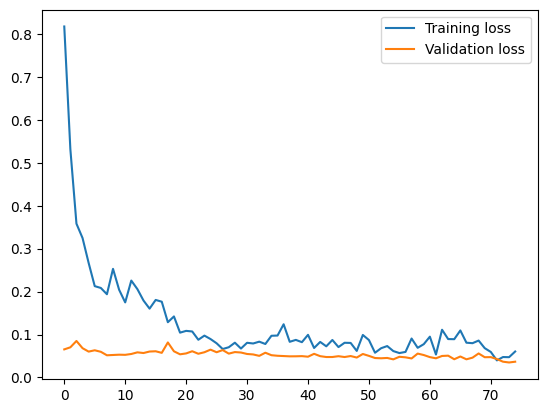

In [265]:
history = model.fit(trainX, trainY, epochs=75, batch_size=16, validation_split=0.1, verbose=0)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [266]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [267]:
n_past = 120
n_months_for_prediction= 60
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_months_for_prediction, freq='D').tolist()


In [274]:

prediction = model.predict(trainX[-24:])
prediction_copies = np.repeat(prediction, df_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [275]:
print(y_pred_future)

[195.55363 189.03078 177.35455 161.45142 151.29695 150.43272 156.61032
 150.68744 147.27448 155.97191 172.17805 191.98477 206.22389 213.2364
 217.68019 216.77809 218.13403 226.79085 232.17474 222.2143  207.58795
 212.2105  230.16092 223.15594]
